<a href="https://colab.research.google.com/github/BuddhikaRoshan/Deep-Learning-Assignment/blob/oshan/IT22569318.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [31]:
data_path = '/content/drive/MyDrive/Python /SE4050-DL-Lecture02-main/DL_Assignment/lung_images.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


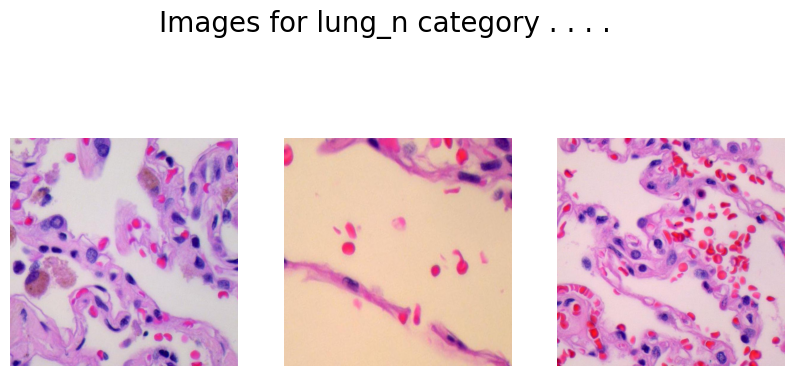

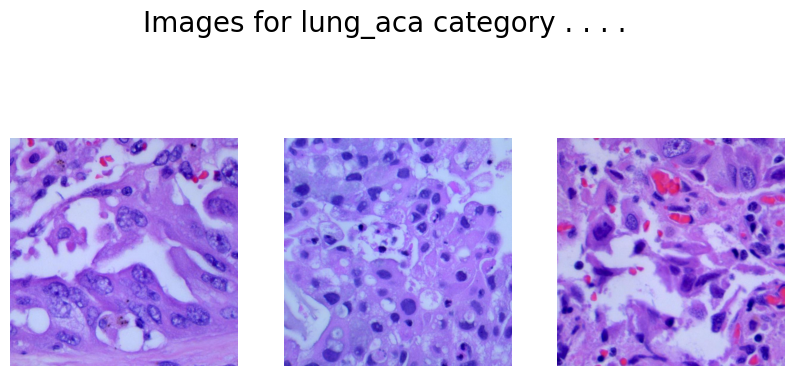

In [44]:
path = 'lung_images'
classes = ['lung_n', 'lung_aca']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [33]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 64

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 960, Validation samples: 240


In [34]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

/tmp/ipython-input-12362989.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [35]:
# Freeze base layers
base_model.trainable = False

In [36]:
# Custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [37]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [38]:
# Callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy reached 90%, stopping training.')
            self.model.stop_training = True

es = EarlyStopping(
    patience=3,
    monitor='val_accuracy',
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.5,
    verbose=1
)

In [39]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.6808 - loss: 0.7688 - val_accuracy: 0.7792 - val_loss: 0.3726
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9538 - loss: 0.1662 - val_accuracy: 0.9208 - val_loss: 0.2211
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.9772 - loss: 0.0801 - val_accuracy: 0.9542 - val_loss: 0.1687
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.9871 - loss: 0.0439 - val_accuracy: 0.9625 - val_loss: 0.1371
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9761 - loss: 0.0612 - val_accuracy: 0.9833 - val_loss: 0.1134
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - accuracy: 0.9813 - loss: 0.0442 - val_accuracy: 0.9792 - val_loss: 0.0884
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9804 - loss: 0.0526 - val_accuracy: 0.9792 - val_loss: 0.0789
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.9895 - loss: 0.0307 - val_accuracy: 0.9833 - val_loss:

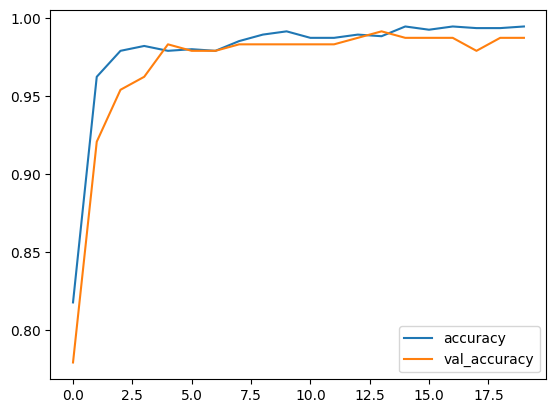

In [42]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [43]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
              precision    recall  f1-score   support

      lung_n       1.00      0.97      0.99       120
    lung_aca       0.98      1.00      0.99       120

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

